In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../../datasets/Combined_Corpus/All_cleaned.csv')
print(df.shape)
df.dropna(subset=['text'], inplace=True)
print(df.shape)

(85270, 4)
(85270, 4)


In [3]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [4]:
df.sample(5)

,text,label,language,category
26388,LONDON â€” Emma Rice will leave her position a...,1,en,ARTS & CULTURE
46445,"Before playing in all of his games, North Caro...",0,en,STYLE & BEAUTY
57300,In a landmark decision that overturned decades...,0,en,POLITICS
11102,The Economic Daily News held an international ...,1,en,ENVIRONMENT
52541,"Paul Burke, who played the upright, soul-searc...",1,en,ENTERTAINMENT


In [ ]:

df = df[df["language"] == "en"]
df.shape

(85094, 4)

In [6]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
def format_for_fasttext(row):
    return f"__label__{row['label']} {row['clean_text']}"

df['fasttext_format'] = df.apply(format_for_fasttext, axis=1)
df['fasttext_format'].to_csv('training.txt', index=False, header=False, sep='\n')


In [ ]:
import fasttext

model_supervised = fasttext.train_supervised(
    input='training.txt', 
    lr=0.01,
    epoch=50,
    wordNgrams=2,
    verbose=2
)

model_supervised.save_model("fasttext_supervised_model.bin")

#model_supervised = fasttext.load_model("fasttext_supervised_model.bin")


Read 31M words
Number of words:  674682
Number of labels: 2
Progress: 100.0% words/sec/thread:  457207 lr:  0.000000 avg.loss:  0.113823 ETA:   0h 0m 0s


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
def tokenize(text):
    return text.split()

class FastTextDataset(Dataset):
    def __init__(self, texts, labels, ft_model, max_len=100):
        
        self.texts = texts
        self.labels = labels
        self.ft_model = ft_model
        self.max_len = max_len
        self.embedding_dim = ft_model.get_dimension()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = tokenize(text)
        embeddings = []
        for token in tokens:
            vec = self.ft_model.get_word_vector(token)  
            embeddings.append(vec)
        if len(embeddings) < self.max_len:
            pad_length = self.max_len - len(embeddings)
            pad = [np.zeros(self.embedding_dim)] * pad_length
            embeddings.extend(pad)
        else:
            embeddings = embeddings[:self.max_len]
        embeddings = torch.tensor(embeddings, dtype=torch.float)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embeddings, label

In [11]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, lstm_hidden_dim, lstm_layers, num_classes, dropout=0.5):
        super(CNN_LSTM_Model, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=num_filters * len(filter_sizes),
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  
        conv_outs = [torch.relu(conv(x)) for conv in self.convs]  
        pooled = [torch.max(conv_out, dim=2)[0] for conv_out in conv_outs]  
        cnn_features = torch.cat(pooled, dim=1)  
        cnn_features = cnn_features.unsqueeze(1)
        lstm_out, (hn, cn) = self.lstm(cnn_features)  
        lstm_out = lstm_out.squeeze(1)  
        out = self.fc(self.dropout(lstm_out))
        return out

In [12]:
texts = df['clean_text'].tolist() 
labels = df['label'].tolist()       

max_len = 500  
embedding_dim = model_supervised.get_dimension()
batch_size = 128
pin_memory = True
num_workers = 4


In [13]:
dataset = FastTextDataset(texts, labels, ft_model=model_supervised, max_len=max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=pin_memory)

In [14]:
model = CNN_LSTM_Model(
    embedding_dim=embedding_dim,
    num_filters=128,
    filter_sizes=[3, 4, 5],
    lstm_hidden_dim=256,
    lstm_layers=2,
    num_classes=2,
    dropout=0.3
)

In [15]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): CNN_LSTM_Model(
    (convs): ModuleList(
      (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 128, kernel_size=(4,), stride=(1,))
      (2): Conv1d(100, 128, kernel_size=(5,), stride=(1,))
    )
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(384, 256, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/cs

Epoch 1/5, Train Loss: 0.2041, Train Acc: 0.9061 | Val Loss: 0.1534, Val Acc: 0.9375


/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/cs

Epoch 2/5, Train Loss: 0.1484, Train Acc: 0.9387 | Val Loss: 0.1447, Val Acc: 0.9403


/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/cs

Epoch 3/5, Train Loss: 0.1431, Train Acc: 0.9411 | Val Loss: 0.1386, Val Acc: 0.9430


/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/cs

Epoch 4/5, Train Loss: 0.1399, Train Acc: 0.9424 | Val Loss: 0.1364, Val Acc: 0.9439


/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_194499/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/cs

Epoch 5/5, Train Loss: 0.1381, Train Acc: 0.9428 | Val Loss: 0.1362, Val Acc: 0.9443
Curba de învățare salvată ca 'learning_curve.png'!


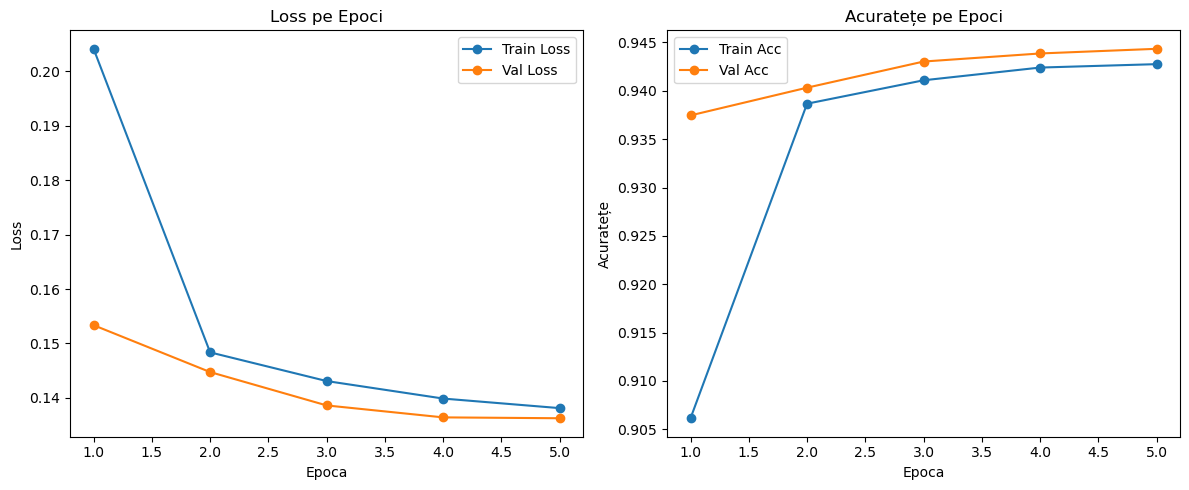

In [ ]:
num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_inputs, batch_labels in dataloader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

    epoch_train_loss = running_loss / len(dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            val_running_loss += loss.item() * batch_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_labels).sum().item()
            val_total += batch_labels.size(0)

    epoch_val_loss = val_running_loss / len(dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


torch.save(model.state_dict(), "fasttext_cnn_lstm.pth")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label="Val Loss")
plt.title('Loss pe Epoci')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label="Train Acc")
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label="Val Acc")
plt.title('Acuratețe pe Epoci')
plt.xlabel('Epoca')
plt.ylabel('Acuratețe')
plt.legend()

plt.tight_layout()
plt.savefig("learning_curve.png")
print("Curba de învățare salvată ca 'learning_curve.png'!")